In [19]:
import random
import torch
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import functional as F
from torch.optim import Adam
from torch_geometric.data import Batch, Data
from torch_geometric.datasets import TUDataset, GeometricShapes
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch_geometric.nn.pool import graclus
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
# from community import community_louvain
from torch_geometric.utils import to_scipy_sparse_matrix
from sklearn.cluster import SpectralClustering, DBSCAN
from os import path
from torch_geometric.nn.pool import graclus, global_mean_pool
from torch_geometric.utils import to_scipy_sparse_matrix
import scipy.sparse.csgraph
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
from torch_geometric.utils import to_networkx

In [20]:
def unsorted_segment_sum(data, segment_ids, num_segments):
    assert all(
        [i in data.shape for i in segment_ids.shape]
    ), "segment_ids.shape should be a prefix of data.shape"

    if len(segment_ids.shape) == 1:
        s = torch.prod(torch.tensor(data.shape[1:], device=data.device)).long()
        segment_ids = segment_ids.repeat_interleave(s).view(
            segment_ids.shape[0], *data.shape[1:]
        )

    assert (
        data.shape == segment_ids.shape
    ), "data.shape and segment_ids.shape should be equal"

    shape = [num_segments] + list(data.shape[1:])
    tensor = torch.zeros(*shape, device=data.device).scatter_add(0, segment_ids, data)
    tensor = tensor.type(data.dtype)
    return tensor


class GraphEncoder(nn.Module):
    def __init__(
        self,
        node_feature_dim,
        edge_feature_dim,
        node_hidden_sizes=None,
        edge_hidden_sizes=None,
        name="graph-encoder",
    ):
        super(GraphEncoder, self).__init__()
        self._node_feature_dim = node_feature_dim
        self._edge_feature_dim = edge_feature_dim
        self._node_hidden_sizes = node_hidden_sizes if node_hidden_sizes else None
        self._edge_hidden_sizes = edge_hidden_sizes
        self._build_model()

    def _build_model(self):
        layer = []
        layer.append(nn.Linear(self._node_feature_dim, self._node_hidden_sizes[0]))
        for i in range(1, len(self._node_hidden_sizes)):
            layer.append(nn.ReLU())
            layer.append(
                nn.Linear(self._node_hidden_sizes[i - 1], self._node_hidden_sizes[i])
            )
        self.MLP1 = nn.Sequential(*layer)

        if self._edge_hidden_sizes is not None:
            layer = []
            layer.append(nn.Linear(self._edge_feature_dim, self._edge_hidden_sizes[0]))
            for i in range(1, len(self._edge_hidden_sizes)):
                layer.append(nn.ReLU())
                layer.append(
                    nn.Linear(
                        self._edge_hidden_sizes[i - 1], self._edge_hidden_sizes[i]
                    )
                )
            self.MLP2 = nn.Sequential(*layer)
        else:
            self.MLP2 = None

    def forward(self, node_features, edge_features=None):
        if self._node_hidden_sizes is None:
            node_outputs = node_features
        else:
            node_outputs = self.MLP1(node_features)
        if edge_features is None or self._edge_hidden_sizes is None:
            edge_outputs = edge_features
        else:
            edge_outputs = self.MLP2(edge_features)

        return node_outputs, edge_outputs


def graph_prop_once(
    node_states,
    from_idx,
    to_idx,
    message_net,
    aggregation_module=None,
    edge_features=None,
):
    from_states = node_states[from_idx]
    to_states = node_states[to_idx]
    edge_inputs = [from_states, to_states]

    if edge_features is not None:
        edge_inputs.append(edge_features)

    edge_inputs = torch.cat(edge_inputs, dim=-1)
    messages = message_net(edge_inputs)

    tensor = unsorted_segment_sum(messages, to_idx, node_states.shape[0])
    return tensor


class GraphPropLayer(nn.Module):
    def __init__(
        self,
        node_state_dim,
        edge_state_dim,
        edge_hidden_sizes,
        node_hidden_sizes,
        edge_net_init_scale=0.1,
        node_update_type="residual",
        use_reverse_direction=True,
        reverse_dir_param_different=True,
        layer_norm=False,
        prop_type="embedding",
        name="graph-net",
    ):
        super(GraphPropLayer, self).__init__()

        self._node_state_dim = node_state_dim
        self._edge_state_dim = edge_state_dim
        self._edge_hidden_sizes = edge_hidden_sizes[:]

        self._node_hidden_sizes = node_hidden_sizes[:] + [node_state_dim]
        self._edge_net_init_scale = edge_net_init_scale
        self._node_update_type = node_update_type

        self._use_reverse_direction = use_reverse_direction
        self._reverse_dir_param_different = reverse_dir_param_different

        self._layer_norm = layer_norm
        self._prop_type = prop_type
        self.build_model()
        self.cross_attention = None

        if self._layer_norm:
            self.layer_norm1 = nn.LayerNorm()
            self.layer_norm2 = nn.LayerNorm()

    def build_model(self):
        layer = []
        layer.append(
            nn.Linear(
                self._node_state_dim * 2 + self._edge_state_dim,
                self._edge_hidden_sizes[0],
            )
        )
        for i in range(1, len(self._edge_hidden_sizes)):
            layer.append(nn.ReLU())
            layer.append(
                nn.Linear(self._edge_hidden_sizes[i - 1], self._edge_hidden_sizes[i])
            )
        self._message_net = nn.Sequential(*layer)

        if self._use_reverse_direction:
            if self._reverse_dir_param_different:
                layer = []
                layer.append(
                    nn.Linear(
                        self._node_state_dim * 2 + self._edge_state_dim,
                        self._edge_hidden_sizes[0],
                    )
                )
                for i in range(1, len(self._edge_hidden_sizes)):
                    layer.append(nn.ReLU())
                    layer.append(
                        nn.Linear(
                            self._edge_hidden_sizes[i - 1], self._edge_hidden_sizes[i]
                        )
                    )
                self._reverse_message_net = nn.Sequential(*layer)
            else:
                self._reverse_message_net = self._message_net

        if self._node_update_type == "gru":
            if self._prop_type == "embedding":
                self.GRU = torch.nn.GRU(self._node_state_dim * 2, self._node_state_dim)
            elif self._prop_type == "matching":
                self.GRU = torch.nn.GRU(self._node_state_dim * 3, self._node_state_dim)
        else:
            layer = []
            if self._prop_type == "embedding":
                layer.append(
                    nn.Linear(self._node_state_dim * 3, self._node_hidden_sizes[0])
                )
            elif self._prop_type == "matching":
                layer.append(
                    nn.Linear(self._node_state_dim * 4, self._node_hidden_sizes[0])
                )
            for i in range(1, len(self._node_hidden_sizes)):
                layer.append(nn.ReLU())
                layer.append(
                    nn.Linear(
                        self._node_hidden_sizes[i - 1], self._node_hidden_sizes[i]
                    )
                )
            self.MLP = nn.Sequential(*layer)

    def _compute_aggregated_messages(
        self, node_states, from_idx, to_idx, edge_features=None
    ):
        aggregated_messages = graph_prop_once(
            node_states,
            from_idx,
            to_idx,
            self._message_net,
            aggregation_module=None,
            edge_features=edge_features,
        )

        if self._use_reverse_direction:
            reverse_aggregated_messages = graph_prop_once(
                node_states,
                to_idx,
                from_idx,
                self._reverse_message_net,
                aggregation_module=None,
                edge_features=edge_features,
            )

            aggregated_messages = aggregated_messages + reverse_aggregated_messages

        if self._layer_norm:
            aggregated_messages = self.layer_norm1(aggregated_messages)

        return aggregated_messages

    def _compute_node_update(self, node_states, node_state_inputs, node_features=None):
        if self._node_update_type in ("mlp", "residual"):
            node_state_inputs.append(node_states)
        if node_features is not None:
            node_state_inputs.append(node_features)

        if len(node_state_inputs) == 1:
            node_state_inputs = node_state_inputs[0]
        else:
            node_state_inputs = torch.cat(node_state_inputs, dim=-1)

        if self._node_update_type == "gru":
            node_state_inputs = torch.unsqueeze(node_state_inputs, 0)
            node_states = torch.unsqueeze(node_states, 0)
            _, new_node_states = self.GRU(node_state_inputs, node_states)
            new_node_states = torch.squeeze(new_node_states)
            return new_node_states
        else:
            mlp_output = self.MLP(node_state_inputs)
            if self._layer_norm:
                mlp_output = nn.self.layer_norm2(mlp_output)
            if self._node_update_type == "mlp":
                return mlp_output
            elif self._node_update_type == "residual":
                return node_states + mlp_output
            else:
                raise ValueError("Unknown node update type %s" % self._node_update_type)

    def forward(
        self, node_states, from_idx, to_idx, edge_features=None, node_features=None
    ):
        aggregated_messages = self._compute_aggregated_messages(
            node_states, from_idx, to_idx, edge_features=edge_features
        )

        return self._compute_node_update(
            node_states, [aggregated_messages], node_features=node_features
        )


class GraphAggregator(nn.Module):
    def __init__(
        self,
        node_hidden_sizes,
        graph_transform_sizes=None,
        input_size=None,
        gated=True,
        aggregation_type="sum",
        name="graph-aggregator",
    ):
        super(GraphAggregator, self).__init__()

        self._node_hidden_sizes = node_hidden_sizes
        self._graph_transform_sizes = graph_transform_sizes
        self._graph_state_dim = node_hidden_sizes[-1]
        self._input_size = input_size
        self._gated = gated
        self._aggregation_type = aggregation_type
        self._aggregation_op = None
        self.MLP1, self.MLP2 = self.build_model()

    def build_model(self):
        node_hidden_sizes = self._node_hidden_sizes
        if self._gated:
            node_hidden_sizes[-1] = self._graph_state_dim * 2

        layer = []
        layer.append(nn.Linear(self._input_size[0], node_hidden_sizes[0]))
        for i in range(1, len(node_hidden_sizes)):
            layer.append(nn.ReLU())
            layer.append(nn.Linear(node_hidden_sizes[i - 1], node_hidden_sizes[i]))
        MLP1 = nn.Sequential(*layer)

        if (
            self._graph_transform_sizes is not None
            and len(self._graph_transform_sizes) > 0
        ):
            layer = []
            layer.append(
                nn.Linear(self._graph_state_dim, self._graph_transform_sizes[0])
            )
            for i in range(1, len(self._graph_transform_sizes)):
                layer.append(nn.ReLU())
                layer.append(
                    nn.Linear(
                        self._graph_transform_sizes[i - 1],
                        self._graph_transform_sizes[i],
                    )
                )
            MLP2 = nn.Sequential(*layer)

        return MLP1, MLP2

    def forward(self, node_states, graph_idx, n_graphs):
        node_states_g = self.MLP1(node_states)

        if self._gated:
            gates = torch.sigmoid(node_states_g[:, : self._graph_state_dim])
            node_states_g = node_states_g[:, self._graph_state_dim :] * gates

        graph_states = unsorted_segment_sum(node_states_g, graph_idx, n_graphs)

        if self._aggregation_type == "max":
            graph_states *= torch.FloatTensor(graph_states > -1e5)

        if (
            self._graph_transform_sizes is not None
            and len(self._graph_transform_sizes) > 0
        ):
            graph_states = self.MLP2(graph_states)

        return graph_states


class GraphEmbeddingNet(nn.Module):
    def __init__(
        self,
        encoder,
        aggregator,
        node_state_dim,
        edge_state_dim,
        edge_hidden_sizes,
        node_hidden_sizes,
        n_prop_layers,
        share_prop_params=False,
        edge_net_init_scale=0.1,
        node_update_type="residual",
        use_reverse_direction=True,
        reverse_dir_param_different=True,
        layer_norm=False,
        layer_class=GraphPropLayer,
        prop_type="embedding",
        name="graph-embedding-net",
    ):
        super(GraphEmbeddingNet, self).__init__()

        self._encoder = encoder
        self._aggregator = aggregator
        self._node_state_dim = node_state_dim
        self._edge_state_dim = edge_state_dim
        self._edge_hidden_sizes = edge_hidden_sizes
        self._node_hidden_sizes = node_hidden_sizes
        self._n_prop_layers = n_prop_layers
        self._share_prop_params = share_prop_params
        self._edge_net_init_scale = edge_net_init_scale
        self._node_update_type = node_update_type
        self._use_reverse_direction = use_reverse_direction
        self._reverse_dir_param_different = reverse_dir_param_different
        self._layer_norm = layer_norm
        self._prop_layers = []
        self._prop_layers = nn.ModuleList()
        self._layer_class = layer_class
        self._prop_type = prop_type
        self.build_model()

    def _build_layer(self, layer_id):
        """Build one layer in the network."""
        return self._layer_class(
            self._node_state_dim,
            self._edge_state_dim,
            self._edge_hidden_sizes,
            self._node_hidden_sizes,
            edge_net_init_scale=self._edge_net_init_scale,
            node_update_type=self._node_update_type,
            use_reverse_direction=self._use_reverse_direction,
            reverse_dir_param_different=self._reverse_dir_param_different,
            layer_norm=self._layer_norm,
            prop_type=self._prop_type,
        )

    def _apply_layer(
        self, layer, node_states, from_idx, to_idx, graph_idx, n_graphs, edge_features
    ):
        del graph_idx, n_graphs
        node_states = layer(node_states, from_idx, to_idx, edge_features=edge_features)
        return node_states

    def build_model(self):
        if len(self._prop_layers) < self._n_prop_layers:
            for i in range(self._n_prop_layers):
                if i == 0 or not self._share_prop_params:
                    layer = self._build_layer(i)
                else:
                    layer = self._prop_layers[0]
                self._prop_layers.append(layer)

    def forward(
        self, node_features, edge_features, from_idx, to_idx, graph_idx, n_graphs
    ):
        node_features, edge_features = self._encoder(node_features, edge_features)
        node_states = node_features

        layer_outputs = [node_states]

        for layer in self._prop_layers:
            node_states = self._apply_layer(
                layer, node_states, from_idx, to_idx, graph_idx, n_graphs, edge_features
            )
            layer_outputs.append(node_states)

        self._layer_outputs = layer_outputs

        return self._aggregator(node_states, graph_idx, n_graphs)

    def reset_n_prop_layers(self, n_prop_layers):
        self._n_prop_layers = n_prop_layers

    @property
    def n_prop_layers(self):
        return self._n_prop_layers

    def get_layer_outputs(self):
        if hasattr(self, "_layer_outputs"):
            return self._layer_outputs
        else:
            raise ValueError("No layer outputs available.")


# def pairwise_cosine_similarity(x, y):
#     x = torch.div(x, torch.sqrt(torch.max(torch.sum(x**2), torch.tensor(1e-12))))
#     y = torch.div(y, torch.sqrt(torch.max(torch.sum(y**2), torch.tensor(1e-12))))
#     return torch.mm(x, torch.transpose(y, 1, 0))


def pairwise_cosine_similarity(a, b):
    a_norm = a / torch.norm(a, dim=1).unsqueeze(-1)
    b_norm = b / torch.norm(b, dim=1).unsqueeze(-1)
    return torch.matmul(a_norm, b_norm.transpose(-2, -1))


def compute_cross_attention(x, y, k=3):
    a = pairwise_cosine_similarity(x, y)
    a_x = torch.softmax(a, dim=1)
    a_y = torch.softmax(a, dim=0)
    attention_x = torch.mm(a_x, y)
    attention_y = torch.mm(torch.transpose(a_y, 1, 0), x)

    top_values_x, top_indices_x = torch.topk(a, k, dim=1)
    top_values_y, top_indices_y = torch.topk(a, k, dim=0)

    return (
        attention_x,
        attention_y,
        a_x,
        a_y,
        (
            top_values_x,
            top_indices_x,
            top_values_y,
            top_indices_y,
        ),
    )


def batch_block_pair_attention(data, block_idx, n_blocks, similarity="cosine"):
    if not isinstance(n_blocks, int):
        raise ValueError("n_blocks (%s) has to be an integer." % str(n_blocks))

    if n_blocks % 2 != 0:
        raise ValueError("n_blocks (%d) must be a multiple of 2." % n_blocks)

    results = []
    topk_cross_attentions = []
    a_x_s = []
    a_y_s = []

    partitions = []
    for i in range(n_blocks):
        partitions.append(data[block_idx == i, :])

    for i in range(0, n_blocks, 2):
        x = partitions[i]
        y = partitions[i + 1]
        (
            attention_x,
            attention_y,
            a_x,
            a_y,
            topk_cross_attention,
        ) = compute_cross_attention(x, y)
        a_x_s.append(a_x)
        a_y_s.append(a_y)
        results.append(attention_x)
        results.append(attention_y)
        topk_cross_attentions.append(topk_cross_attention)
    results = torch.cat(results, dim=0)

    return results, topk_cross_attentions, a_x_s, a_y_s


class GraphPropMatchingLayer(GraphPropLayer):
    def forward(
        self,
        node_states,
        from_idx,
        to_idx,
        graph_idx,
        n_graphs,
        similarity="cosine",
        edge_features=None,
        node_features=None,
    ):
        aggregated_messages = self._compute_aggregated_messages(
            node_states, from_idx, to_idx, edge_features=edge_features
        )

        (
            cross_graph_attention,
            topk_cross_attentions,
            a_x_s,
            a_y_s,
        ) = batch_block_pair_attention(
            node_states, graph_idx, n_graphs, similarity=similarity
        )
        self.cross_attention = (cross_graph_attention, topk_cross_attentions, a_x_s, a_y_s)
        attention_input = node_states - cross_graph_attention
        return self._compute_node_update(
            node_states,
            [aggregated_messages, attention_input],
            node_features=node_features,
        )


class GraphMatchingNet(GraphEmbeddingNet):
    def __init__(
        self,
        encoder,
        aggregator,
        node_state_dim,
        edge_state_dim,
        edge_hidden_sizes,
        node_hidden_sizes,
        n_prop_layers,
        share_prop_params=False,
        edge_net_init_scale=0.1,
        node_update_type="residual",
        use_reverse_direction=True,
        reverse_dir_param_different=True,
        layer_norm=False,
        layer_class=GraphPropLayer,
        similarity="cosine",
        prop_type="embedding",
    ):
        super(GraphMatchingNet, self).__init__(
            encoder,
            aggregator,
            node_state_dim,
            edge_state_dim,
            edge_hidden_sizes,
            node_hidden_sizes,
            n_prop_layers,
            share_prop_params=share_prop_params,
            edge_net_init_scale=edge_net_init_scale,
            node_update_type=node_update_type,
            use_reverse_direction=use_reverse_direction,
            reverse_dir_param_different=reverse_dir_param_different,
            layer_norm=layer_norm,
            layer_class=GraphPropMatchingLayer,
            prop_type=prop_type,
        )
        self._similarity = similarity

    def _apply_layer(
        self, layer, node_states, from_idx, to_idx, graph_idx, n_graphs, edge_features
    ):
        return layer(
            node_states,
            from_idx,
            to_idx,
            graph_idx,
            n_graphs,
            similarity=self._similarity,
            edge_features=edge_features,
        )

Total number of graphs: 188
Number of classes: 2
Number of node features: 7
Average number of nodes per graph: 17
Max number of nodes in a graph: 28
Min number of nodes in a graph: 10
Class distribution:
 - Class 0: 63 graphs (33.51%)
 - Class 1: 125 graphs (66.49%)


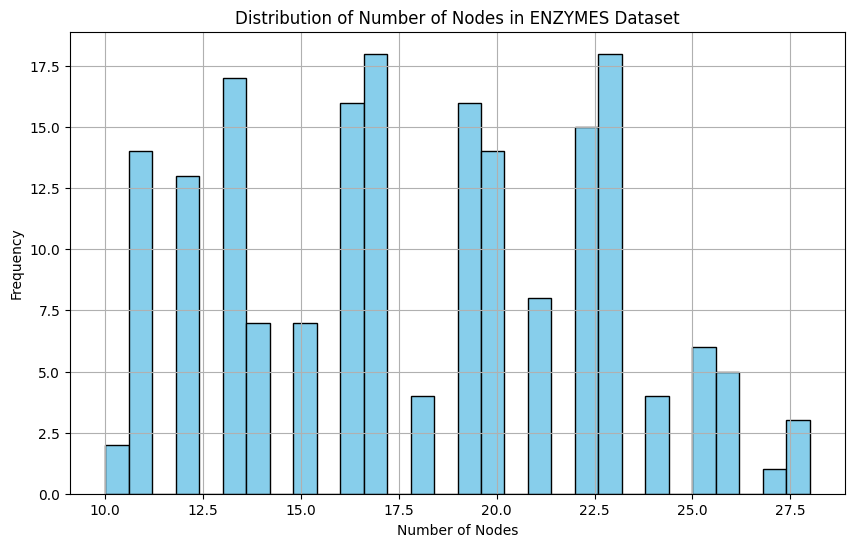

Small graphs: 188
Medium graphs: 0
Large graphs: 0


In [21]:
def analyze_dataset(dataset):
    num_graphs = len(dataset)
    num_classes = dataset.num_classes if hasattr(dataset, 'num_classes') else None
    num_node_features = dataset.num_node_features if hasattr(dataset, 'num_node_features') else None
    labels = [data.y.item() for data in dataset]
    num_nodes = [data.num_nodes for data in dataset]
    class_distribution = Counter(labels)
    avg_num_nodes = sum(num_nodes) / len(num_nodes)
    min_nodes = min(num_nodes)
    max_nodes = max(num_nodes)
    
    small_threshold = 30
    large_threshold = 60

    small_graphs = []
    medium_graphs = []
    large_graphs = []

    classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }
    
    for i in dataset:
        c = i.y
        class_name = "class_" + str(c.item())
        classes[class_name].append(i)
    
    print(f'Total number of graphs: {num_graphs}')
    if num_classes:
        print(f'Number of classes: {num_classes}')
    if num_node_features:
        print(f'Number of node features: {num_node_features}')
    print(f'Average number of nodes per graph: {int(avg_num_nodes)}')
    print(f'Max number of nodes in a graph: {max_nodes}')
    print(f'Min number of nodes in a graph: {min_nodes}')

    print('Class distribution:')
    for cls, count in class_distribution.items():
        print(f' - Class {cls}: {count} graphs ({100 * count / num_graphs:.2f}%)')
        
    plt.figure(figsize=(10, 6))
    plt.hist(num_nodes, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Number of Nodes in ENZYMES Dataset')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    for graph in dataset:
        if graph.num_nodes < small_threshold:
            small_graphs.append(graph)
        elif graph.num_nodes > large_threshold:
            large_graphs.append(graph)
        else:
            medium_graphs.append(graph)

    print(f"Small graphs: {len(small_graphs)}")
    print(f"Medium graphs: {len(medium_graphs)}")
    print(f"Large graphs: {len(large_graphs)}")
    
    return small_graphs, medium_graphs, large_graphs, classes

dataset = TUDataset(
    root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
).shuffle()

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [22]:
class Args:
    def __init__(self):
        self.dim = 64
        self.feat_dim = dataset.num_features
        self.num_layers = 8
        self.margin = 0.5
        self.lr = 0.0001
        self.n_classes = dataset.num_classes
        self.batch_size = 128
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 1000

args = Args()

In [23]:
def get_default_config():
    """The default configs."""
    model_type = "matching"
    node_state_dim = 16
    edge_state_dim = 4
    graph_rep_dim = 128
    graph_embedding_net_config = dict(
        node_state_dim=node_state_dim,
        edge_state_dim=edge_state_dim,
        edge_hidden_sizes=[node_state_dim * 2, node_state_dim * 2],
        node_hidden_sizes=[node_state_dim * 8],
        n_prop_layers=4,
        share_prop_params=True,
        edge_net_init_scale=0.1,
        node_update_type="gru",
        use_reverse_direction=True,
        reverse_dir_param_different=False,
        layer_norm=False,
        prop_type=model_type,
    )
    graph_matching_net_config = graph_embedding_net_config.copy()
    graph_matching_net_config["similarity"] = "cosine"
    return dict(
        encoder=dict(
            node_hidden_sizes=[node_state_dim],
            node_feature_dim=1,
            edge_hidden_sizes=[edge_state_dim],
        ),
        aggregator=dict(
            node_hidden_sizes=[graph_rep_dim],
            graph_transform_sizes=[graph_rep_dim],
            input_size=[node_state_dim],
            gated=True,
            aggregation_type="sum",
        ),
        graph_embedding_net=graph_embedding_net_config,
        graph_matching_net=graph_matching_net_config,
        model_type=model_type,
        data=dict(
            problem="graph_edit_distance",
            dataset_params=dict(
                n_nodes_range=[100, 200],
                p_edge_range=[0.2, 0.25],
                n_changes_positive=1,
                n_changes_negative=2,
                validation_dataset_size=1000,
            ),
        ),
        training=dict(
            batch_size=args.batch_size,
            learning_rate=1e-4,
            mode="pair",
            loss="margin",
            margin=args.margin,
            graph_vec_regularizer_weight=1e-6,
            clip_value=10.0,
            n_training_steps=5000,
            print_after=100,
            eval_after=10,
        ),
        evaluation=dict(batch_size=20),
        seed=42,
    )

config = get_default_config()

In [24]:
config["encoder"]["node_feature_dim"] = dataset.num_node_features
config["encoder"]["edge_feature_dim"] = 4
encoder = GraphEncoder(**config["encoder"])
aggregator = GraphAggregator(**config["aggregator"])
model = GraphMatchingNet(encoder, aggregator, **config["graph_matching_net"])
optimizer = torch.optim.Adam(
    (model.parameters()), lr=config["training"]["learning_rate"], weight_decay=1e-5
)

In [25]:
def convert_graph(graph):
    from_idx = graph.edge_index[0]
    to_idx = graph.edge_index[1]
    num_edges = graph.edge_index.shape[1]
    graph_idx = np.zeros(graph.x.shape[0], dtype=int)
    node_features = graph.x
    edge_features = torch.ones((num_edges, 4), dtype=torch.float32).requires_grad_(True)
    return node_features, edge_features, from_idx, to_idx, graph_idx


def reshape_and_split_tensor(tensor, n_splits):
    feature_dim = tensor.shape[-1]
    tensor = torch.reshape(tensor, [-1, feature_dim * n_splits])
    tensor_split = []
    for i in range(n_splits):
        tensor_split.append(tensor[:, feature_dim * i : feature_dim * (i + 1)])
    return tensor_split


def similarity(gmn, graph1, graph2):
    (
        g1_node_features,
        g1_edge_features,
        g1_from_idx,
        g1_to_idx,
        g1_graph_idx,
    ) = convert_graph(graph1)
    (
        g2_node_features,
        g2_edge_features,
        g2_from_idx,
        g2_to_idx,
        g2_graph_idx,
    ) = convert_graph(graph2)
    
    gmn.eval()

    stacked_node_features = torch.cat([g1_node_features, g2_node_features], dim=0)
    stacked_edge_features = torch.cat([g1_edge_features, g2_edge_features], dim=0)

    offset = max(g1_from_idx.max(), g1_to_idx.max()) + 1
    adjusted_g2_from_idx = g2_from_idx + offset
    adjusted_g2_to_idx = g2_to_idx + offset

    stacked_from_idx = torch.cat([g1_from_idx, adjusted_g2_from_idx], dim=0)
    stacked_to_idx = torch.cat([g1_to_idx, adjusted_g2_to_idx], dim=0)

    graph_idx_first = torch.zeros(g1_node_features.size(0), dtype=int)
    graph_idx_second = torch.ones(g2_node_features.size(0), dtype=int)
    stacked_graph_idx = torch.cat([graph_idx_first, graph_idx_second], dim=0)

    graph_vectors = gmn(
        stacked_node_features,
        stacked_edge_features,
        stacked_from_idx,
        stacked_to_idx,
        stacked_graph_idx,
        2,
    )

    x, y = reshape_and_split_tensor(graph_vectors, 2)
    similarity = cosine_similarity(x.detach().numpy(), y.detach().numpy())

    return f"{similarity.item():.4f}"

In [26]:
def convert_batch(graphs):
    batch_node_features = []
    batch_edge_features = []
    batch_from_idx = []
    batch_to_idx = []
    batch_graph_idx = []
    classes = []
    
    current_max_node_idx = 0
    for i, graph in enumerate(graphs):
        num_nodes = graph.x.size(0)
        num_edges = graph.edge_index.size(1)
        
        node_features = graph.x
        edge_features = torch.ones((num_edges, 4), dtype=torch.float32).requires_grad_(True)
        
        from_idx = graph.edge_index[0] + current_max_node_idx
        to_idx = graph.edge_index[1] + current_max_node_idx
        graph_idx = torch.full((num_nodes,), i, dtype=torch.long)
        
        current_max_node_idx += num_nodes
        
        batch_node_features.append(node_features)
        batch_edge_features.append(edge_features)
        batch_from_idx.append(from_idx)
        batch_to_idx.append(to_idx)
        batch_graph_idx.append(graph_idx)
        classes.append(graph.y)
    
    batch_node_features = torch.cat(batch_node_features, dim=0)
    batch_edge_features = torch.cat(batch_edge_features, dim=0)
    batch_from_idx = torch.cat(batch_from_idx, dim=0)
    batch_to_idx = torch.cat(batch_to_idx, dim=0)
    batch_graph_idx = torch.cat(batch_graph_idx, dim=0)
    batch_classes = torch.cat(classes, dim=0)
    
    return ((batch_node_features, batch_edge_features, batch_from_idx, batch_to_idx, batch_graph_idx), batch_classes)

In [27]:
def compute_similarity(embeddings, classes):
    similarity_scores = []
    labels = []
    
    for i in range(0, len(embeddings), 2):
        embedding1 = embeddings[i].unsqueeze(0)
        embedding2 = embeddings[i + 1].unsqueeze(0)
        
        similarity_score = torch.norm(embedding1 - embedding2, p=2, dim=1)
        similarity_scores.append(similarity_score)
        
        label = 1 if classes[i] == classes[i + 1] else -1
        labels.append(label)
    
    similarity_scores = torch.cat(similarity_scores)
    labels = torch.tensor(labels, dtype=torch.float)
    
    return similarity_scores, labels


def calculate_loss_and_accuracy(similarity_scores, labels, margin):
    loss = torch.relu(margin - labels * (1 - similarity_scores)).mean()
    predicted_similar = torch.where(similarity_scores > margin, torch.ones_like(labels), -torch.ones_like(labels))
    # acc = (predicted_similar == labels).float().mean()
    predictions = torch.where(similarity_scores < margin, 1, -1)
    correct_predictions = torch.eq(predictions, labels).sum().item()
    total_predictions = labels.size(0)
    acc = correct_predictions / total_predictions
    return loss, acc

In [28]:
def train(model, dataset, visualize=False, epochs=700):
    train_losses = []
    train_accuracies = []
    model.train()
    for epoch in range(epochs):
        dataset = dataset.shuffle()
        batch = dataset[:args.batch_size]
        optimizer.zero_grad()
        converted_batch, classes = convert_batch(batch)
        predictions = model(*converted_batch, args.batch_size)
        similarity_scores, labels = compute_similarity(predictions, classes)
        loss, acc = calculate_loss_and_accuracy(similarity_scores, labels, args.margin)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())
        train_accuracies.append(acc)
        
        if epoch % 100 == 0:
            print(f"Loss: {loss.item():.4f} - Acc: {acc:.4f}")
         
    if visualize:    
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

In [29]:
def plot_graphs(edge_index, layer_clusters, graph1, graph2, sim, title=""):
    num_rows = len(layer_clusters)
    fig, axes = plt.subplots(num_rows, 4, figsize=(32, num_rows * 8))
    
    if num_rows > 1:
        x_pos = axes[0][1].get_position().x1 + (axes[0][2].get_position().x0 - axes[0][1].get_position().x1) / 2
        fig.patches.extend([plt.Rectangle((x_pos, 0), 0.001, 0.95, transform=fig.transFigure, color='black')])
        fig.text(0.25, 0.95, f'Graph1 ({graph1})', ha='center', va='center', fontsize=17)
        fig.text(0.75, 0.95, f'Graph2 ({graph2})', ha='center', va='center', fontsize=17)
        fig.text(0.5, 0.97, f"Sim: {sim}", ha='center', va='center', fontsize=17)
    else:
        x_pos = axes[1].get_position().x1 + (axes[2].get_position().x0 - axes[1].get_position().x1) / 2
        fig.patches.extend([plt.Rectangle((x_pos, 0), 0.001, 0.9, transform=fig.transFigure, color='black')])
        fig.text(0.25, 0.9, f'Graph1 ({graph1})', ha='center', va='center', fontsize=17)
        fig.text(0.75, 0.9, f'Graph2 ({graph2})', ha='center', va='center', fontsize=17)
        fig.text(0.5, 0.95, f"Sim: {sim:.4f}", ha='center', va='center', fontsize=17)
    

    fig.suptitle(title, fontsize=20, va='bottom', ha='center')
    
    axes = axes.flatten()
        
    def draw_graph(ax, G, title, node_colors):
        pos = nx.spring_layout(G) 
        if node_colors:
            nx.draw(G, pos, ax=ax, with_labels=True, node_color=node_colors, cmap=plt.get_cmap('viridis'))
        else:
            nx.draw(G, pos, ax=ax, with_labels=True)
        ax.set_title(title)

    for i, clusters in enumerate(layer_clusters):
        ax_index = 4 * i
        G_clustered = nx.Graph()
        for source, target in edge_index[0].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[0][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 1
        G = nx.Graph()
        G.add_edges_from(edge_index[0].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[0])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[0]):
            supergraph.add_node(cls.item())
        for (n1, n2) in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)
        
        ax_index = 4 * i + 2
        G_clustered = nx.Graph()
        for source, target in edge_index[1].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[1][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 3
        G = nx.Graph()
        G.add_edges_from(edge_index[1].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[1])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[1]):
            supergraph.add_node(cls.item())
        for (n1, n2) in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)

    plt.tight_layout()
    if num_rows > 1:
        fig.subplots_adjust(top=0.9)
    else:
        fig.subplots_adjust(top=0.8)
    plt.show()
    
def create_clustered_graph(cluster, edge_index):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    supernode_mapping = {node: int(cls) for node, cls in enumerate(cluster)}
    supergraph = nx.Graph()
    for cls in torch.unique(cluster):
        supergraph.add_node(cls.item())
    for (n1, n2) in G.edges():
        sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
        if sn1 != sn2:
            supergraph.add_edge(sn1, sn2)
    return supergraph

def cdm(node_embeddings, epsilon=1e-6, tau=0.5):
    exp_embeddings = torch.exp(node_embeddings)
    sum_exp_embeddings = torch.sum(exp_embeddings, dim=1, keepdim=True)
    q_i_tilde = exp_embeddings / sum_exp_embeddings
    max_q_i_tilde = torch.max(q_i_tilde, dim=1, keepdim=True).values
    q_i = q_i_tilde / (max_q_i_tilde + epsilon)
    r_i = (q_i >= tau).int()    
    class_assignments = r_i.tolist()
    node_classes = [assignment.index(1) if 1 in assignment else -1 for assignment in class_assignments]
    
    return torch.tensor(node_classes)

In [30]:
# model.eval()

# c = "class_0"
# idx1, idx2 = random.sample(range(len(classes[c])), 2)
# graph1, graph2 = classes[c][idx1], classes[c][idx2]

# print(f"Graph 1: {graph1} - Class: {graph1.y.item()}")
# print(f"Graph 2 : {graph2} - Class: {graph2.y.item()}")
# sim = similarity(model, graph1, graph2)
# print(f"Similarity: {sim}")

# layer_outputs = model.get_layer_outputs()

# clusters1 = []
# clusters2 = []
# clusters = []
# for l in layer_outputs:
#     o1 = l[:graph1.num_nodes]
#     o2 = l[graph1.num_nodes:]
#     cluster1 = torch.tensor(agglomerative.fit_predict(o1.detach().numpy()))
#     clusters1.append(cluster1)
#     cluster2 = torch.tensor(agglomerative.fit_predict(o2.detach().numpy()))
#     clusters2.append(cluster2)
#     clusters.append((cluster1, cluster2))
    
# unq1 = []
# for cluster in clusters1:
#     unq1.append(len(cluster.unique())) 
# print(f"  Graph 1: {unq1}")

# unq2 = []
# for cluster in clusters2:
#     unq2.append(len(cluster.unique()))
# print(f"  Graph 2: {unq2}")

# for i in range(len(clusters1)):
#     G1 = create_clustered_graph(clusters1[i], graph1.edge_index)
#     G2 = create_clustered_graph(clusters2[i], graph2.edge_index)
#     print(f"  Layer {i+1}: {nx.is_isomorphic(G1, G2)}")
    
# plot_graphs([graph1.edge_index, graph2.edge_index], clusters, graph1, graph2)

Loss: 2.5326 - Acc: 0.4688
Loss: 0.4103 - Acc: 0.4844
Loss: 0.2601 - Acc: 0.5156
Loss: 0.2683 - Acc: 0.6250
Loss: 0.3013 - Acc: 0.6094
Loss: 0.3124 - Acc: 0.7031
Loss: 0.2538 - Acc: 0.7344
Loss: 0.2509 - Acc: 0.6250
Loss: 0.2171 - Acc: 0.7969
Loss: 0.2207 - Acc: 0.8281
Loss: 0.1617 - Acc: 0.7031
Loss: 0.1849 - Acc: 0.6250
Loss: 0.2118 - Acc: 0.6250
Loss: 0.1849 - Acc: 0.7812
Loss: 0.2166 - Acc: 0.6406


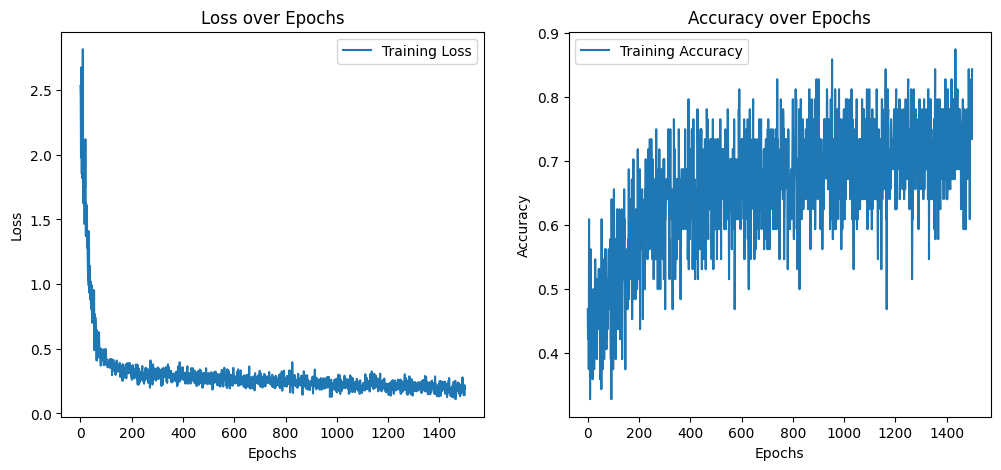

In [31]:
layers = 6

config["graph_matching_net"]["n_prop_layers"] = layers
model = GraphMatchingNet(encoder, aggregator, **config["graph_matching_net"])
optimizer = torch.optim.Adam(
    (model.parameters()), lr=config["training"]["learning_rate"], weight_decay=1e-5
)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Apply custom weight initialization
model.apply(initialize_weights)

filename = f"checkpoints_v2/checkpoint_{dataset.name.lower()}_{str(args.dim)}_cross_test_temp.pth"

if path.exists(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(args.device)
    model.to(args.device)
else:
    train(model, dataset, True, epochs=1500)
    # torch.save({
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #         }, filename)

In [36]:
cs = ["class_0", "class_1"]
c = cs[0]
# for c in cs:
#     for _ in range(5):
idx1, idx2 = random.sample(range(len(classes[c])), 2)
graph1, graph2 = classes[c][idx1], classes[c][idx2]

print(f"Graph 1: {graph1} - Class: {graph1.y.item()}")
print(f"Graph 2 : {graph2} - Class: {graph2.y.item()}")
sim = similarity(model, graph1, graph2)
print(f"Similarity: {sim}")

layer_outputs = model.get_layer_outputs()

cdm_clusters = []
for l in layer_outputs:
    o1 = l[:graph1.num_nodes]
    o2 = l[graph1.num_nodes:]
    cdm_cluster1 = cdm(o1)
    cdm_cluster2 = cdm(o2)
    cdm_clusters.append((cdm_cluster1, cdm_cluster2))

title = f"Num layers: {layers} | Class: {c} | Method: "
    
# plot_graphs([graph1.edge_index, graph2.edge_index], cdm_clusters, graph1, graph2, sim, title+"CDM")

Graph 1: Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1]) - Class: 0
Graph 2 : Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1]) - Class: 0
Similarity: 0.8555


In [33]:
def normalize_attention(a_x_s):
    a_min, a_max = a_x_s.min(), a_x_s.max()
    if a_max > a_min:
        return (a_x_s - a_min) / (a_max - a_min)
    return a_x_s


def visualize_graphs_with_attention(graph1, graph2, a_x_s, a_y_s, threshold=0.9, topk=None):
    G1 = to_networkx(graph1, to_undirected=True)
    G2 = to_networkx(graph2, to_undirected=True)
    
    pos1 = nx.kamada_kawai_layout(G1)
    pos2 = nx.kamada_kawai_layout(G2)

    pos2_shifted = {k: [v[0] + 3, v[1]] for k, v in pos2.items()}

    plt.figure(figsize=(24, 14))
    nx.draw(G1, pos1, with_labels=True, node_color='skyblue', edge_color='k', node_size=700)
    nx.draw(G2, pos2_shifted, with_labels=True, node_color='lightcoral', edge_color='k', node_size=700)

    combined_pos = {**pos1, **{k + len(G1): v for k, v in pos2_shifted.items()}}
    
    a_x_s = normalize_attention(a_x_s)
    a_y_s = normalize_attention(a_y_s).T
    
    def keep_topk(tensor, k):
        topk_values, topk_indices = torch.topk(tensor, k=k, dim=1)
        zero_tensor = torch.zeros_like(tensor)
        zero_tensor.scatter_(1, topk_indices, topk_values)

        return zero_tensor
    
    if topk:
        a_x_s = keep_topk(a_x_s, topk)
        a_y_s = keep_topk(a_y_s, topk)

    for i, j in torch.nonzero(a_x_s > threshold):
        src = i.item()
        target = j.item() + len(G1)
        weight = a_x_s[i, j].item()
        plt.plot([combined_pos[src][0], combined_pos[target][0]],
                 [combined_pos[src][1], combined_pos[target][1]],
                 color='blue', alpha=min(weight * 5, 1.0), lw=weight * 2)

    for i, j in torch.nonzero(a_y_s > threshold):
        src = i.item() + len(G1)
        target = j.item()
        weight = a_y_s[i, j].item()
        plt.plot([combined_pos[src][0], combined_pos[target][0]],
                 [combined_pos[src][1], combined_pos[target][1]],
                 color='red', alpha=min(weight * 5, 1.0), lw=weight * 2)

    plt.axis('off')
    plt.show()

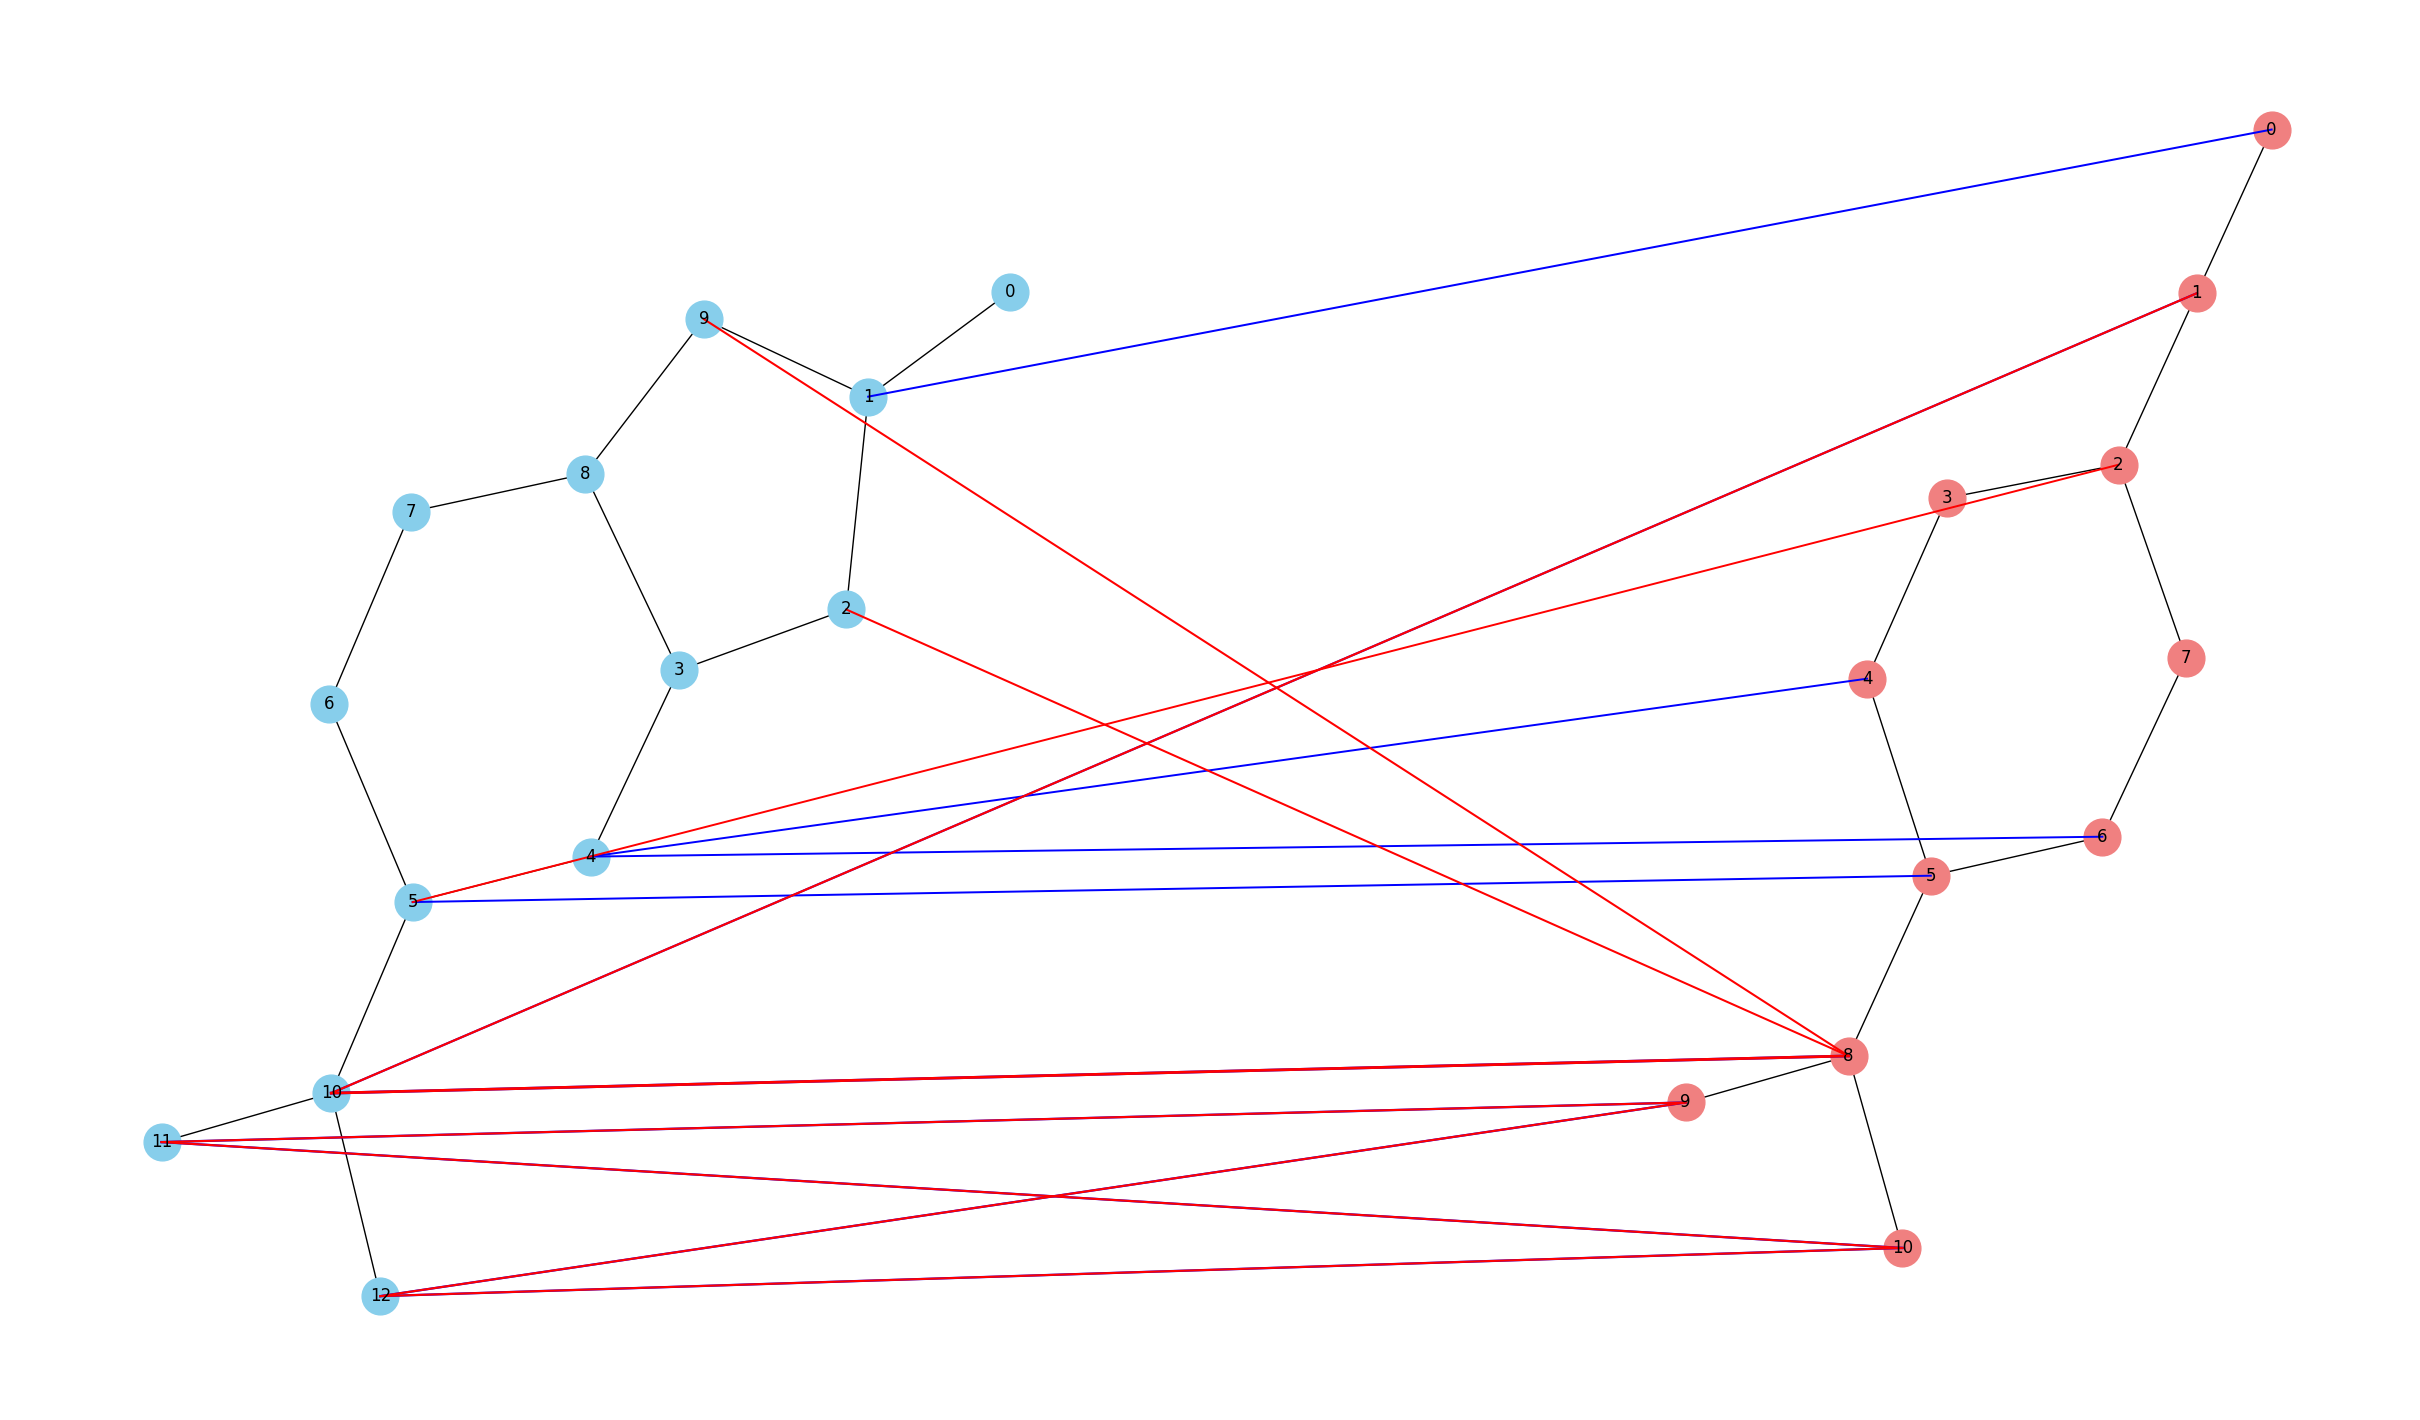

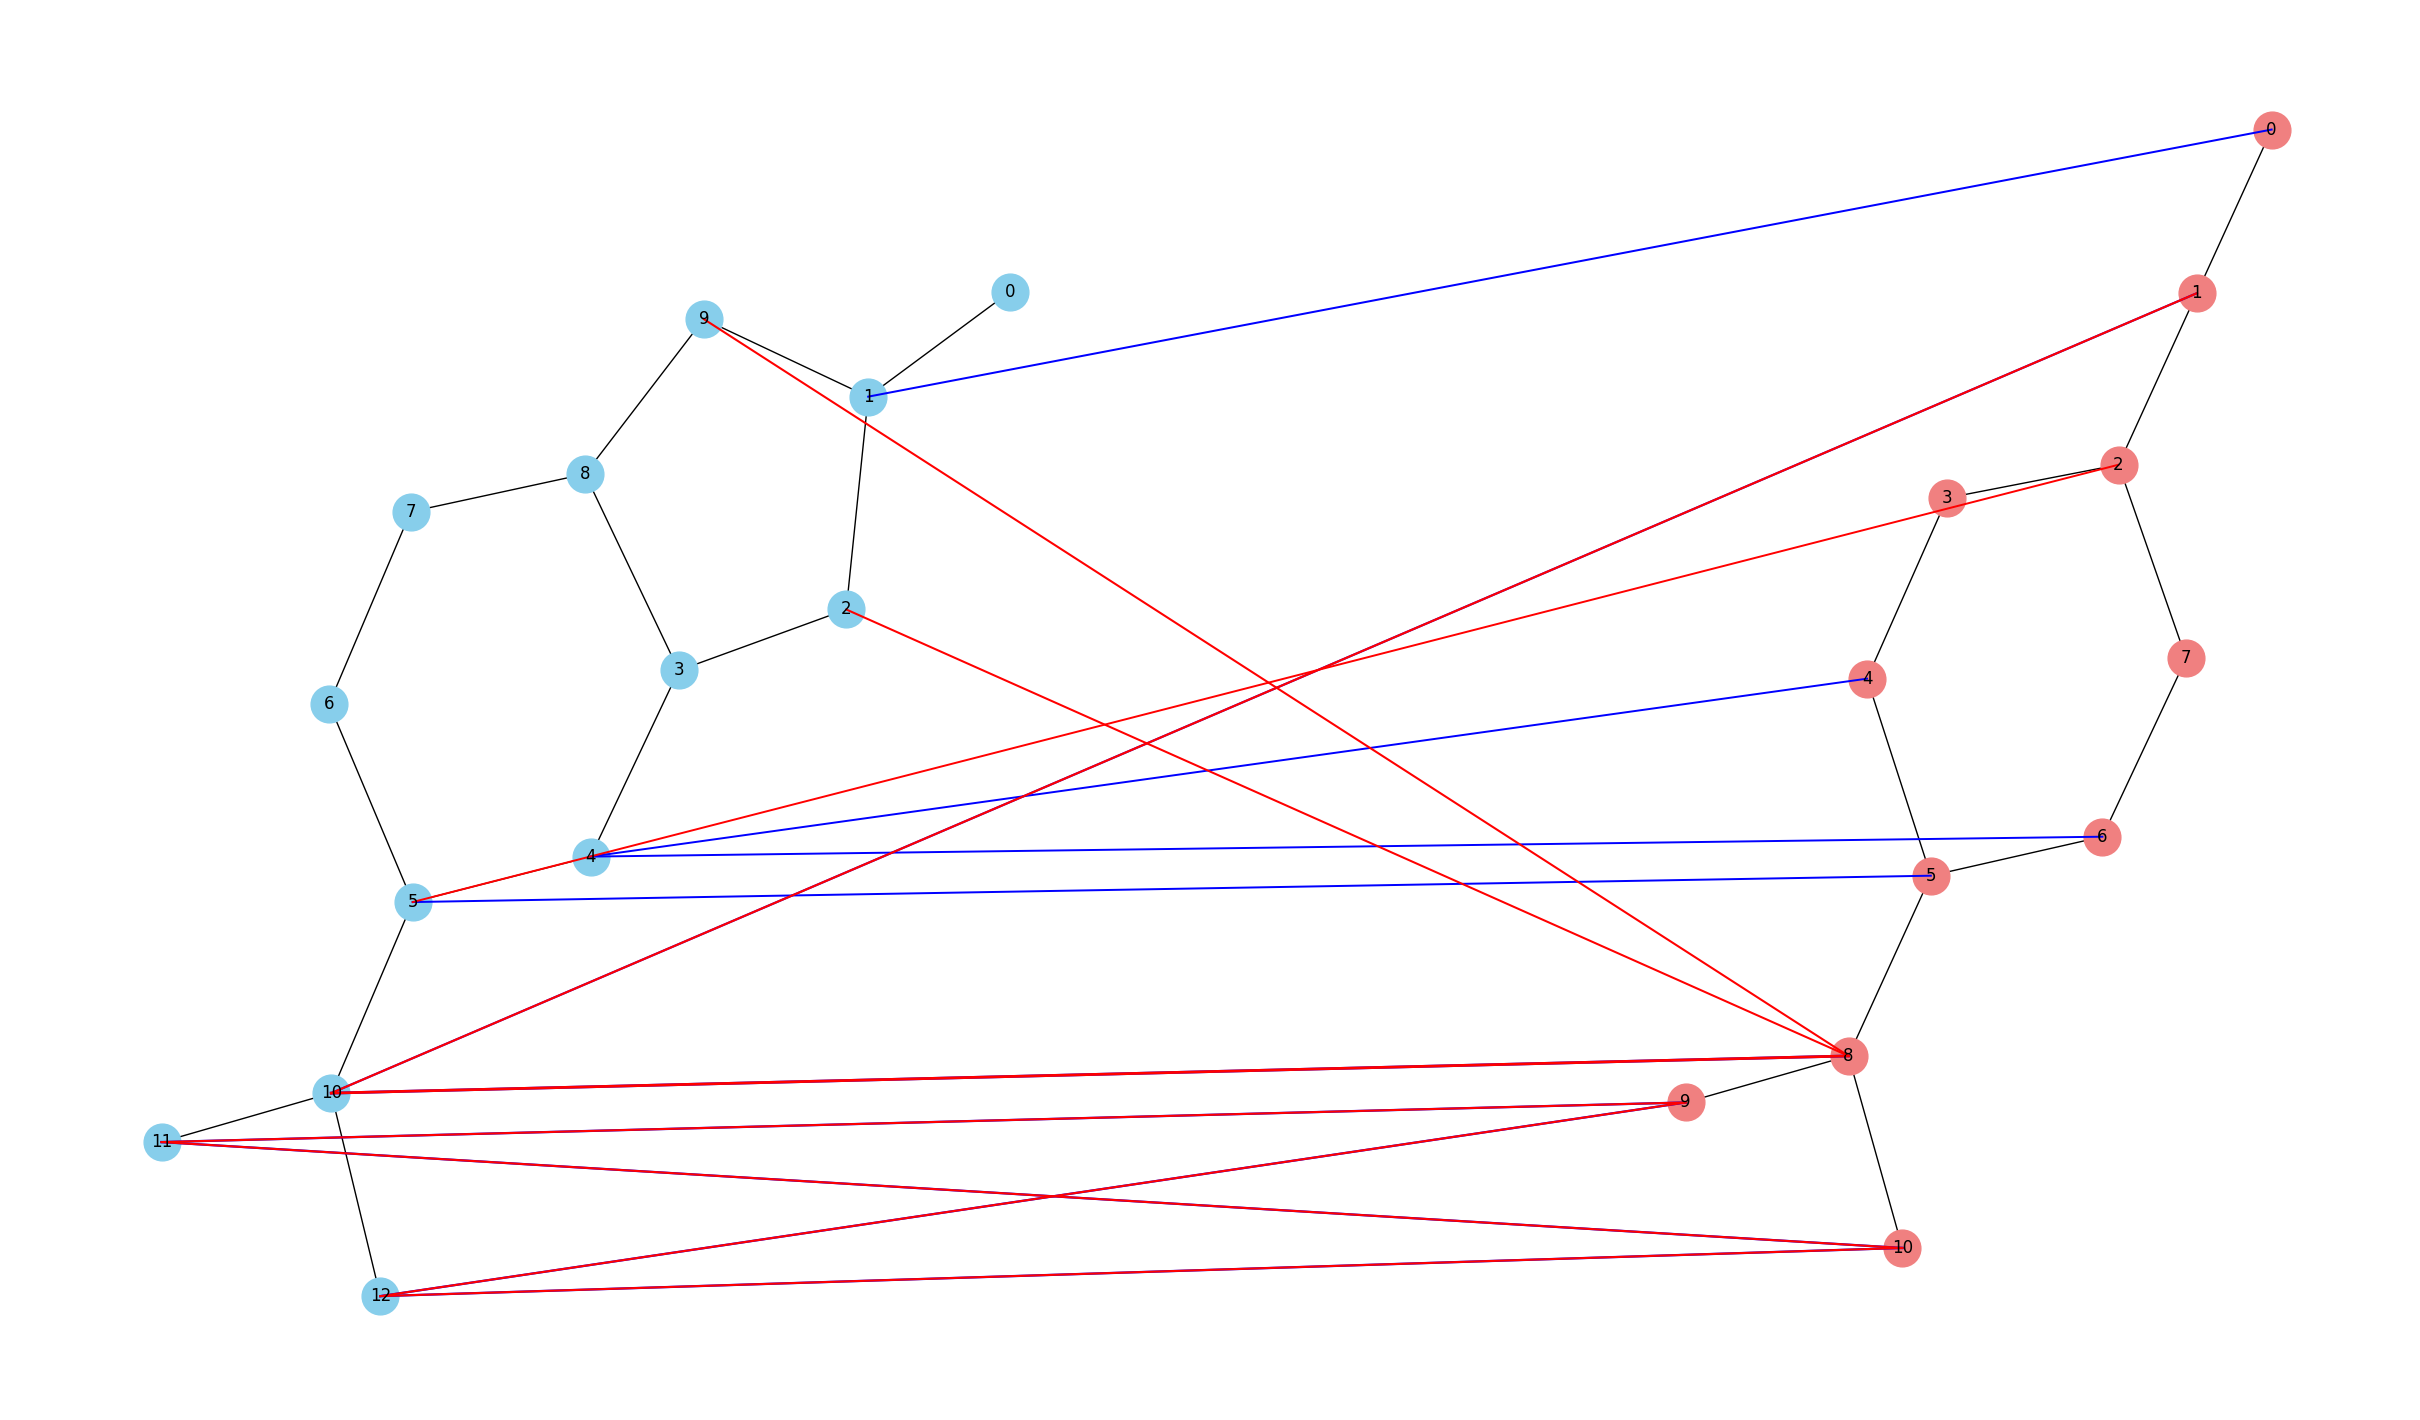

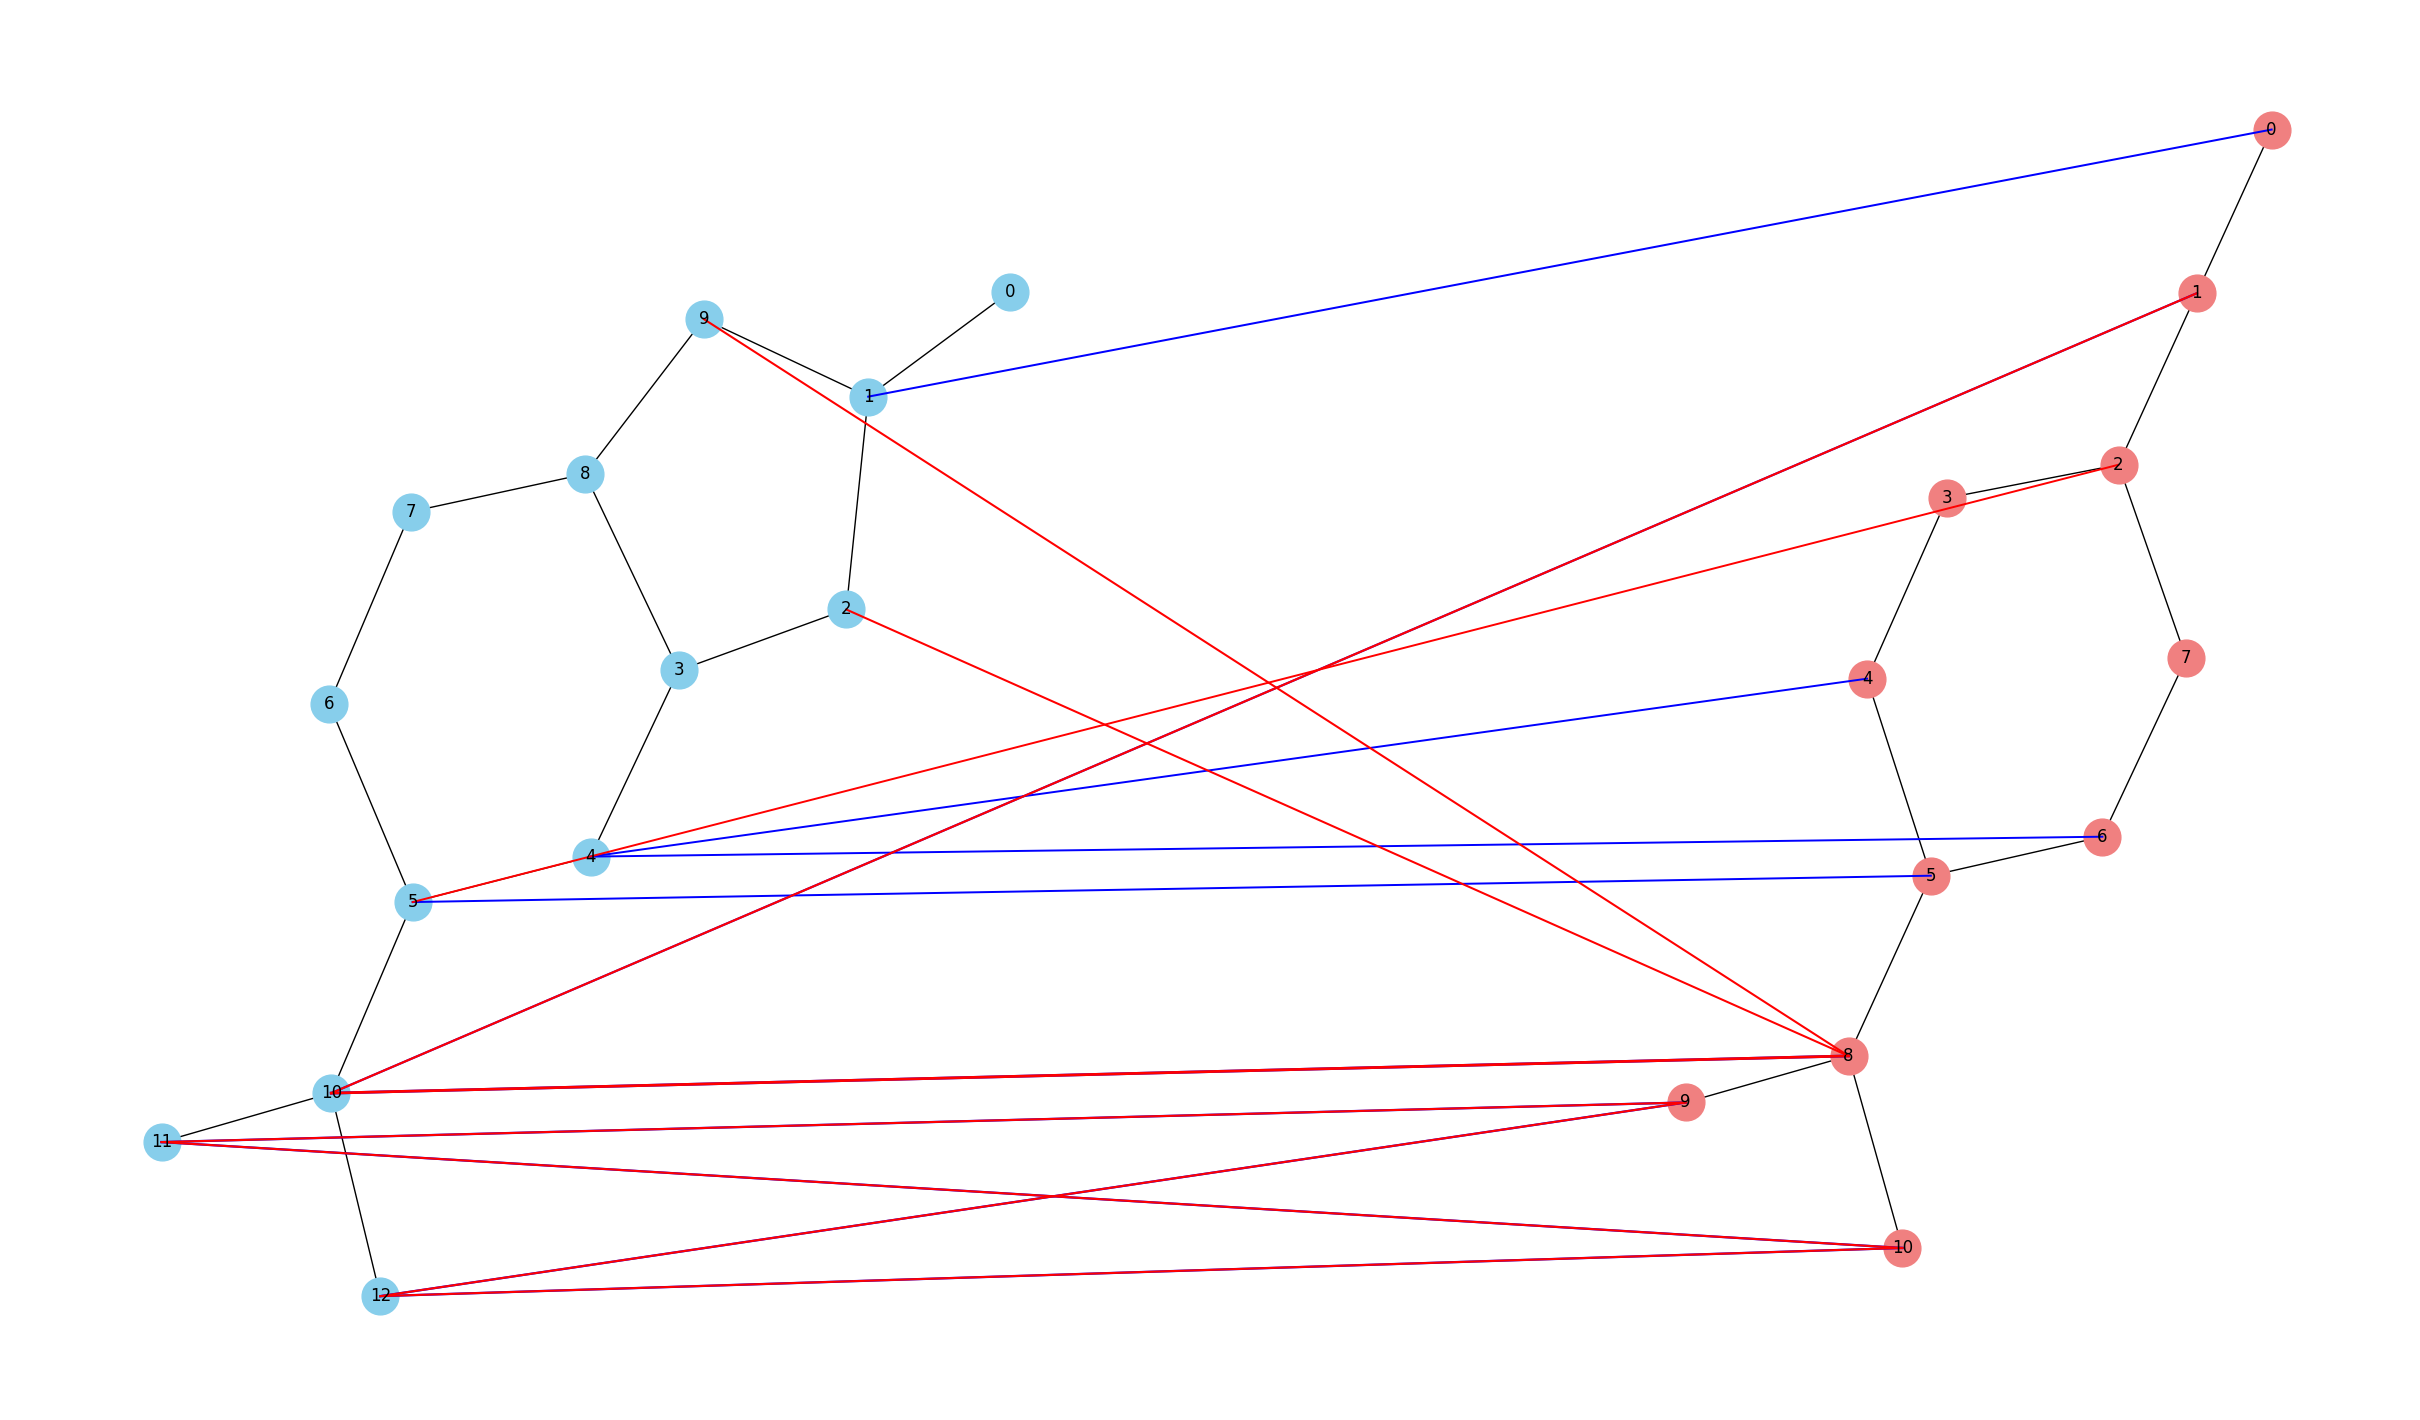

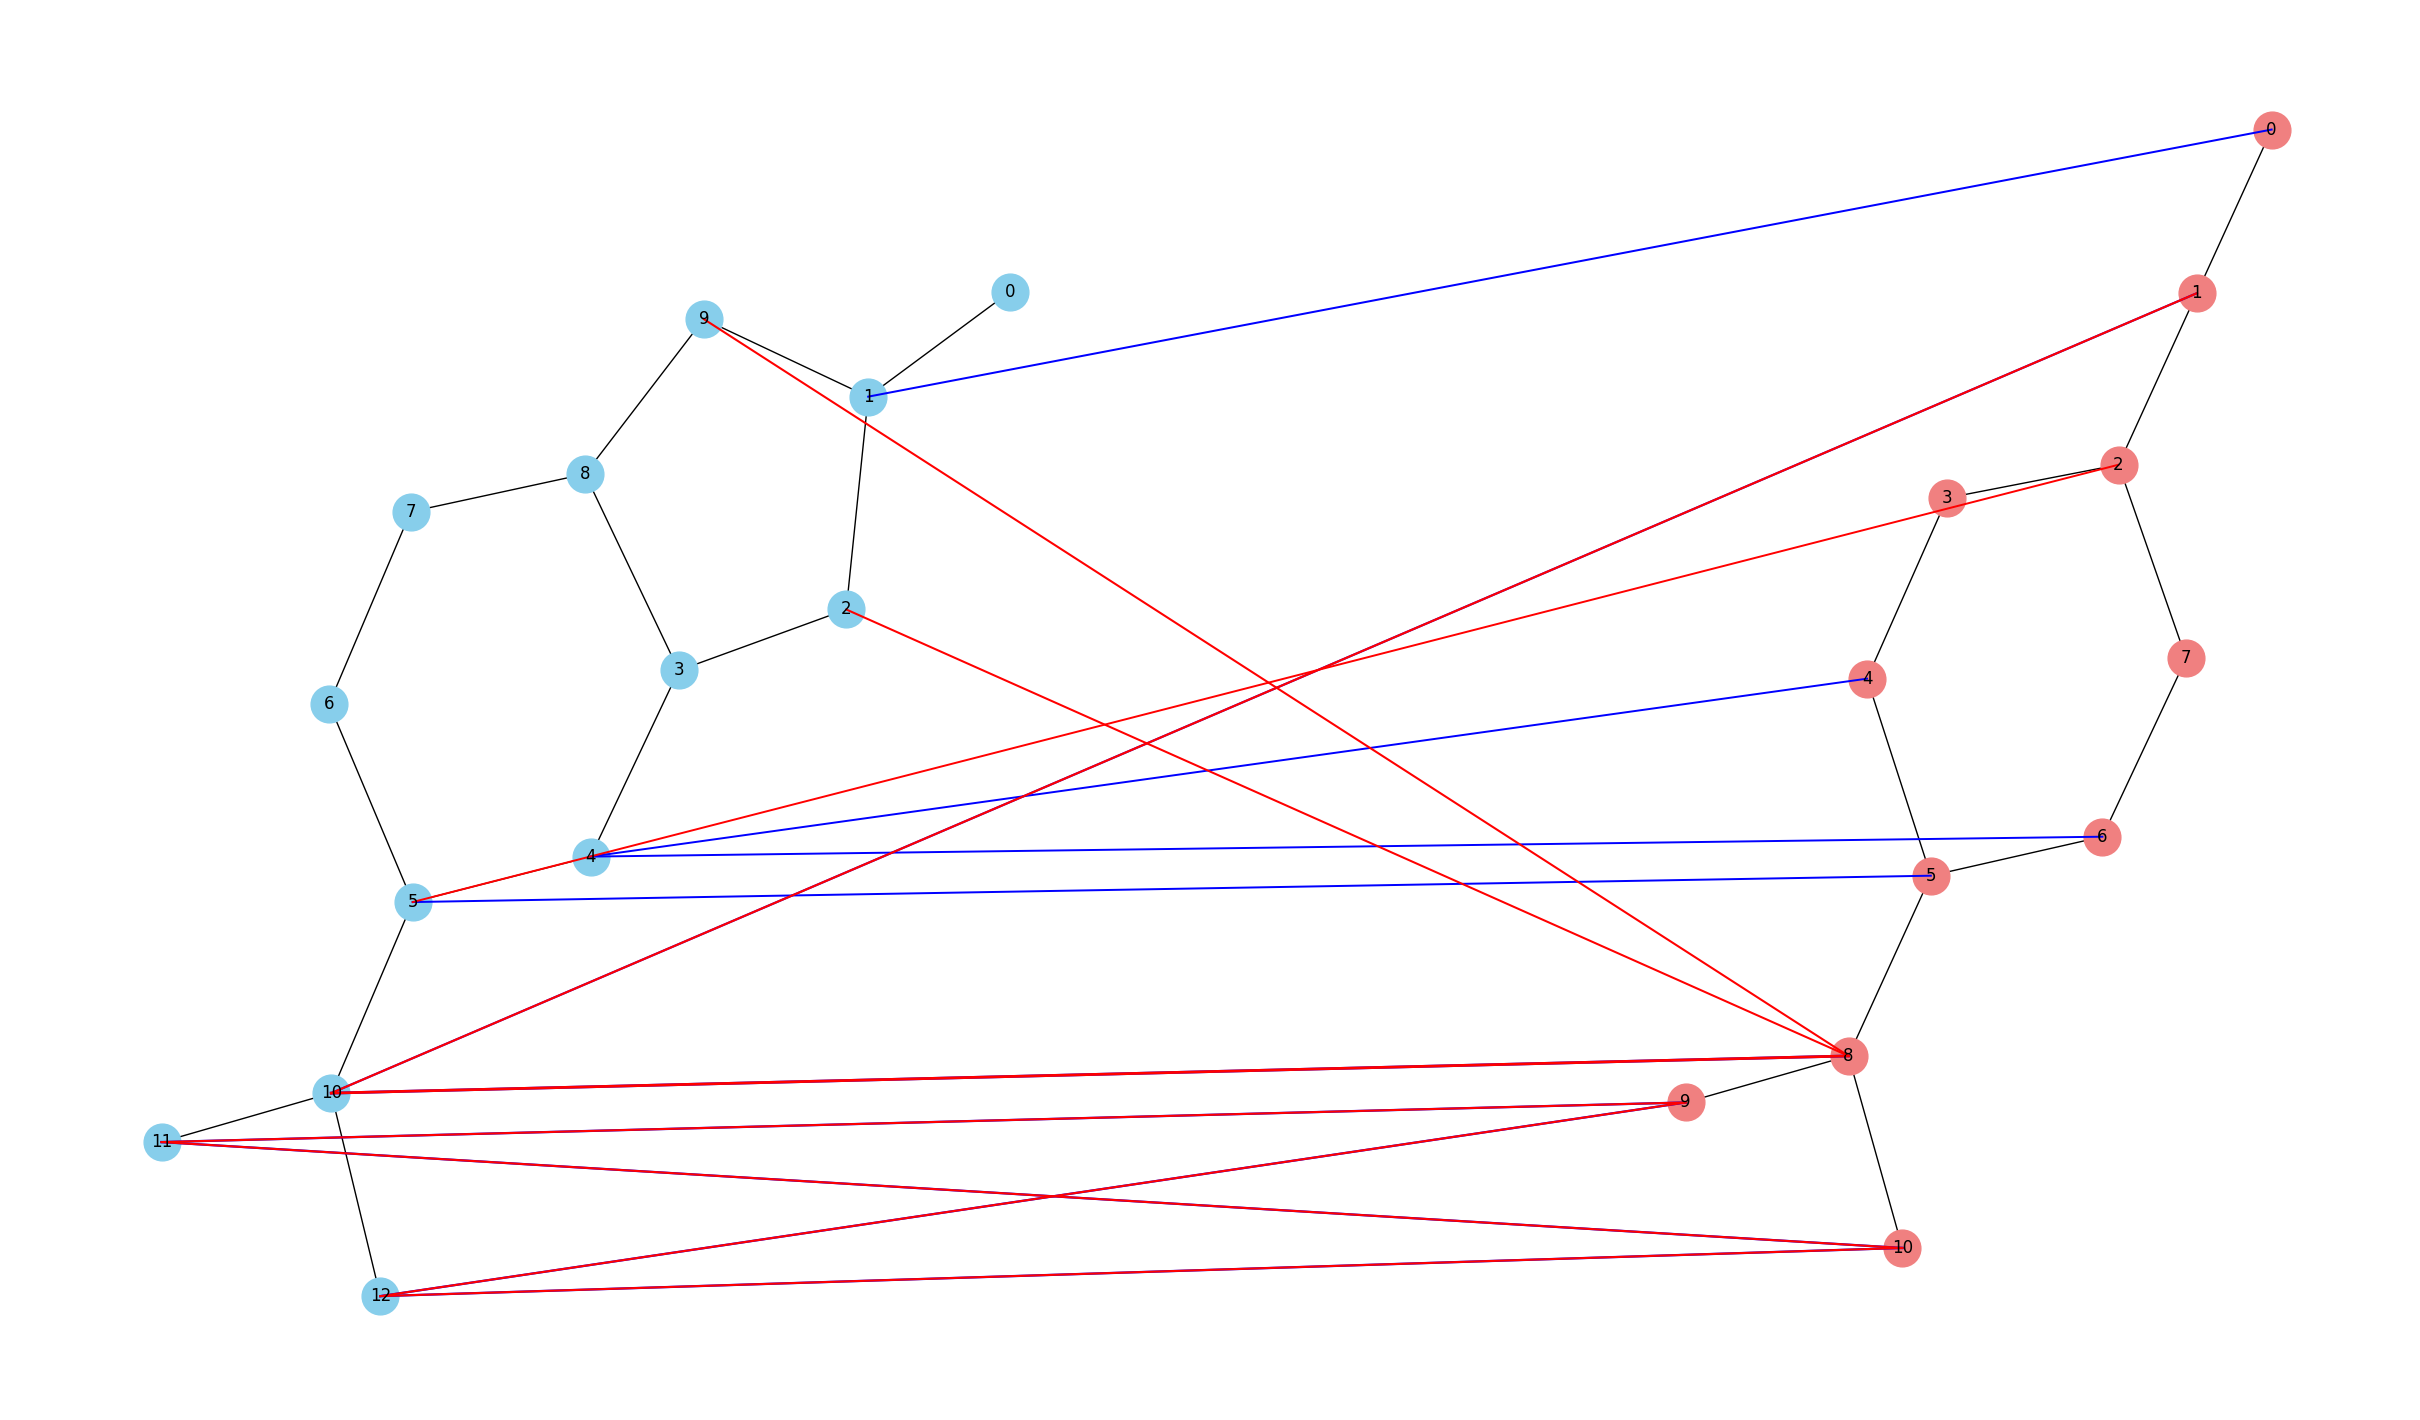

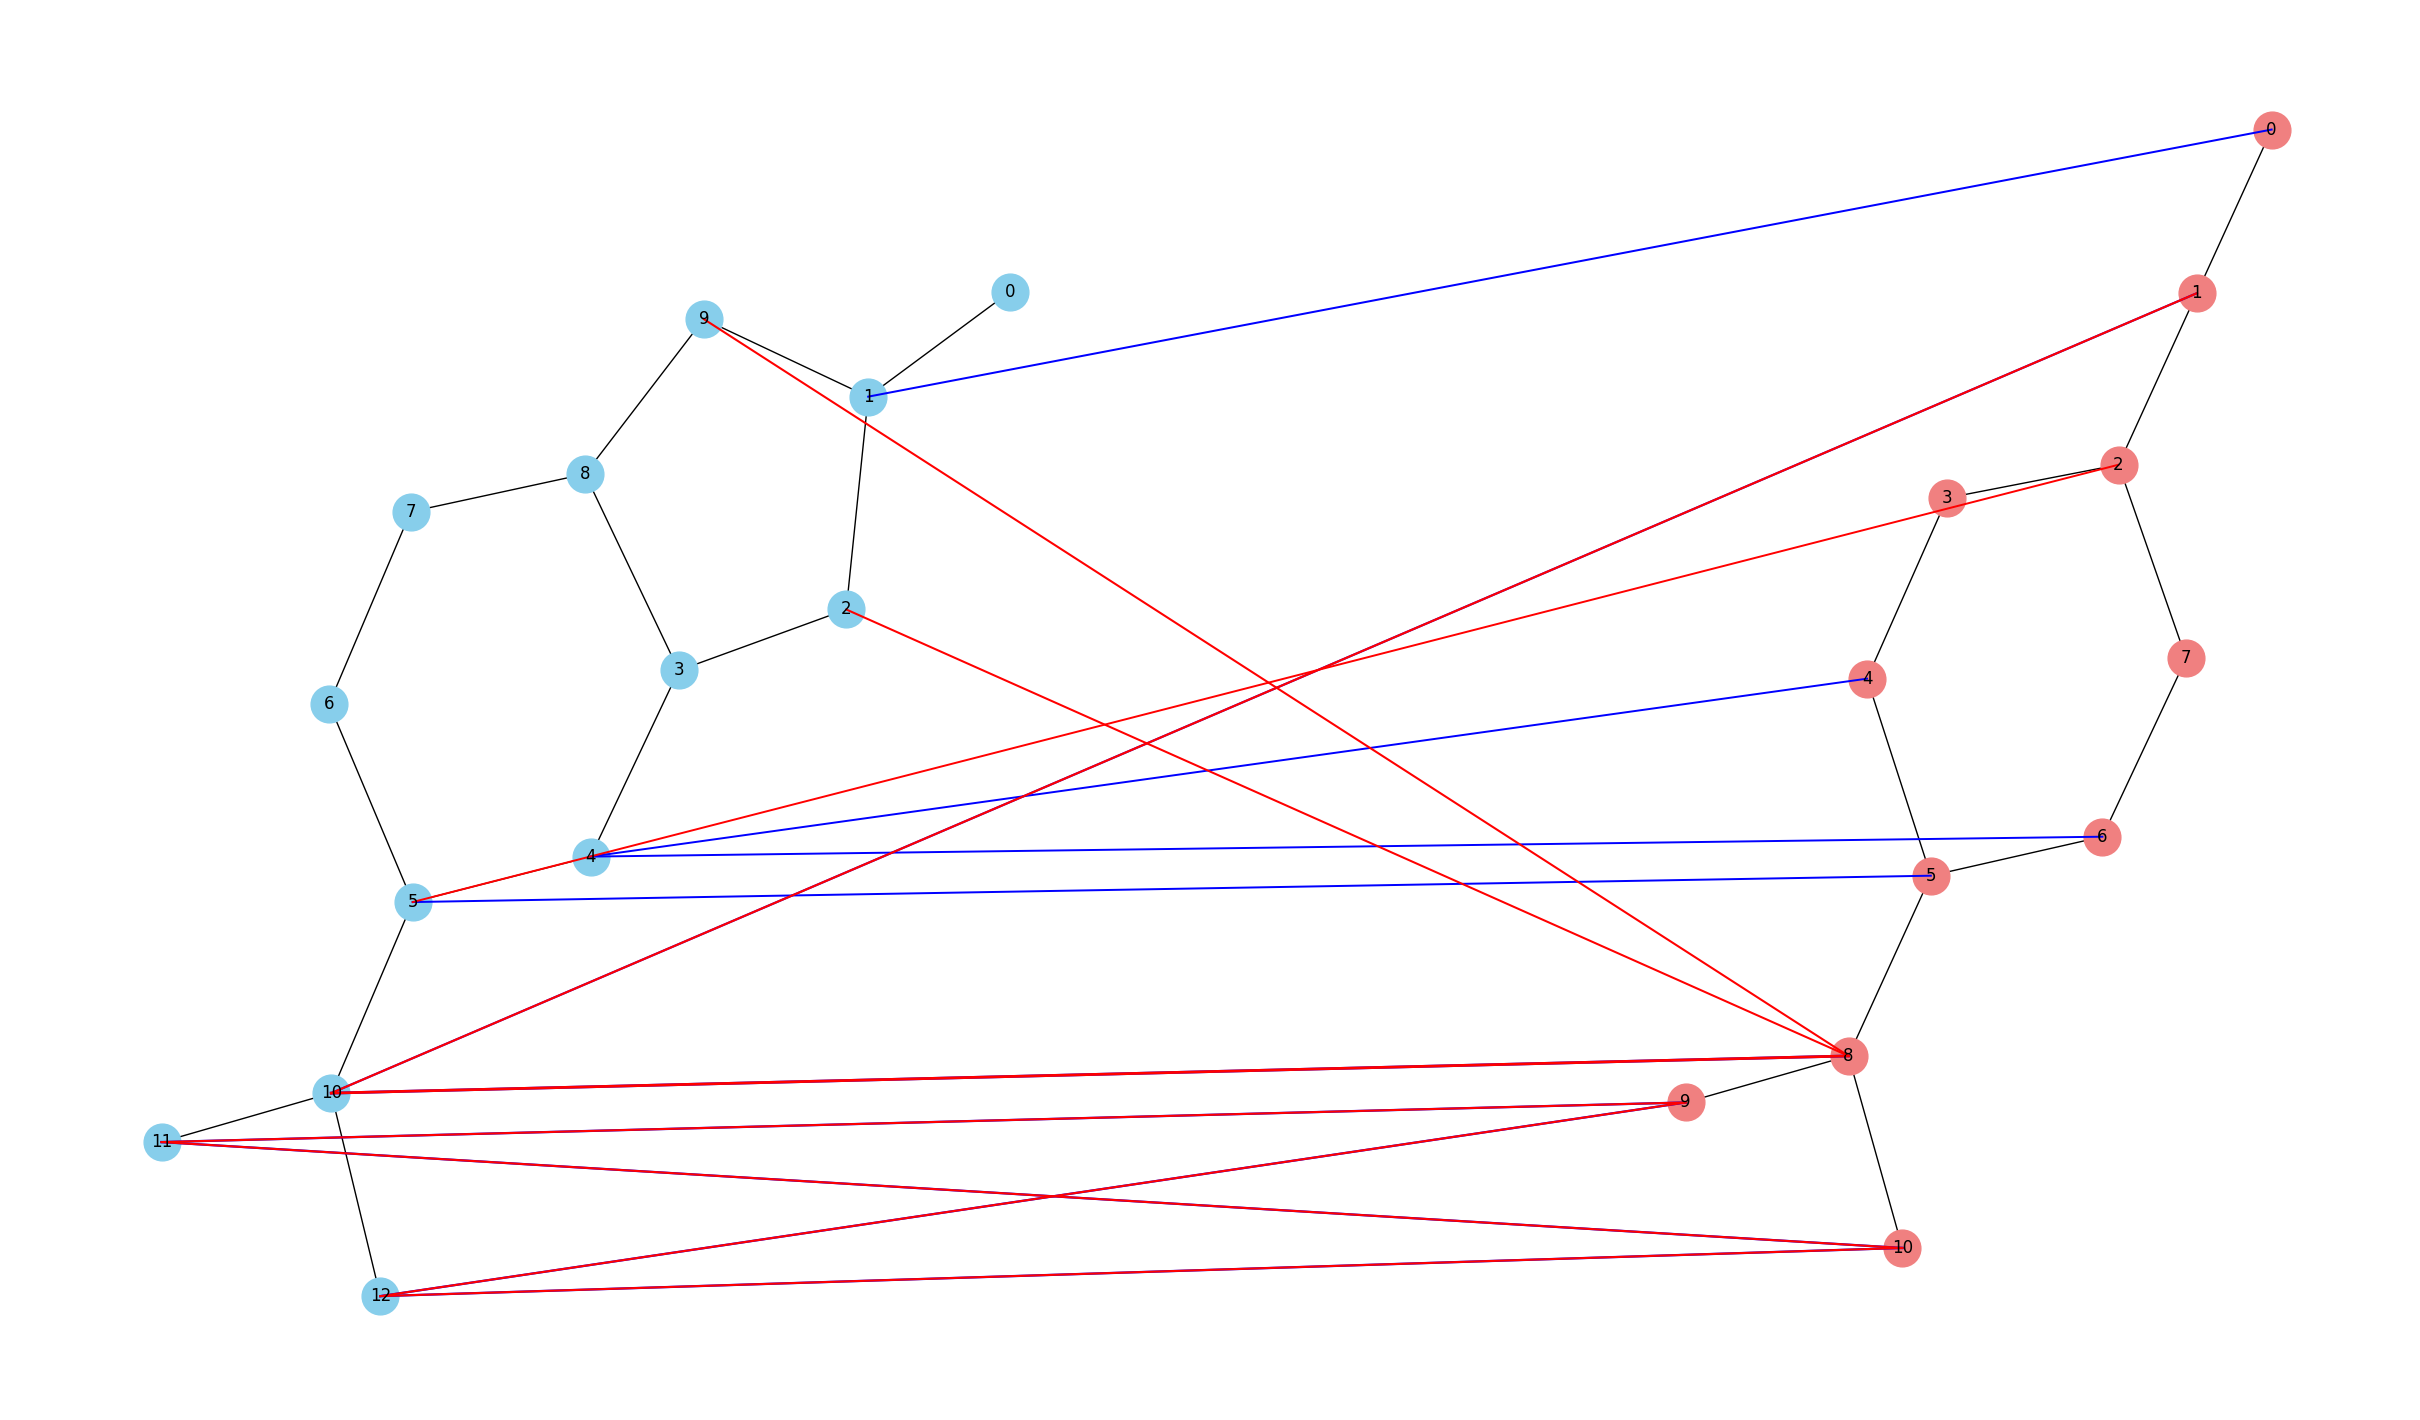

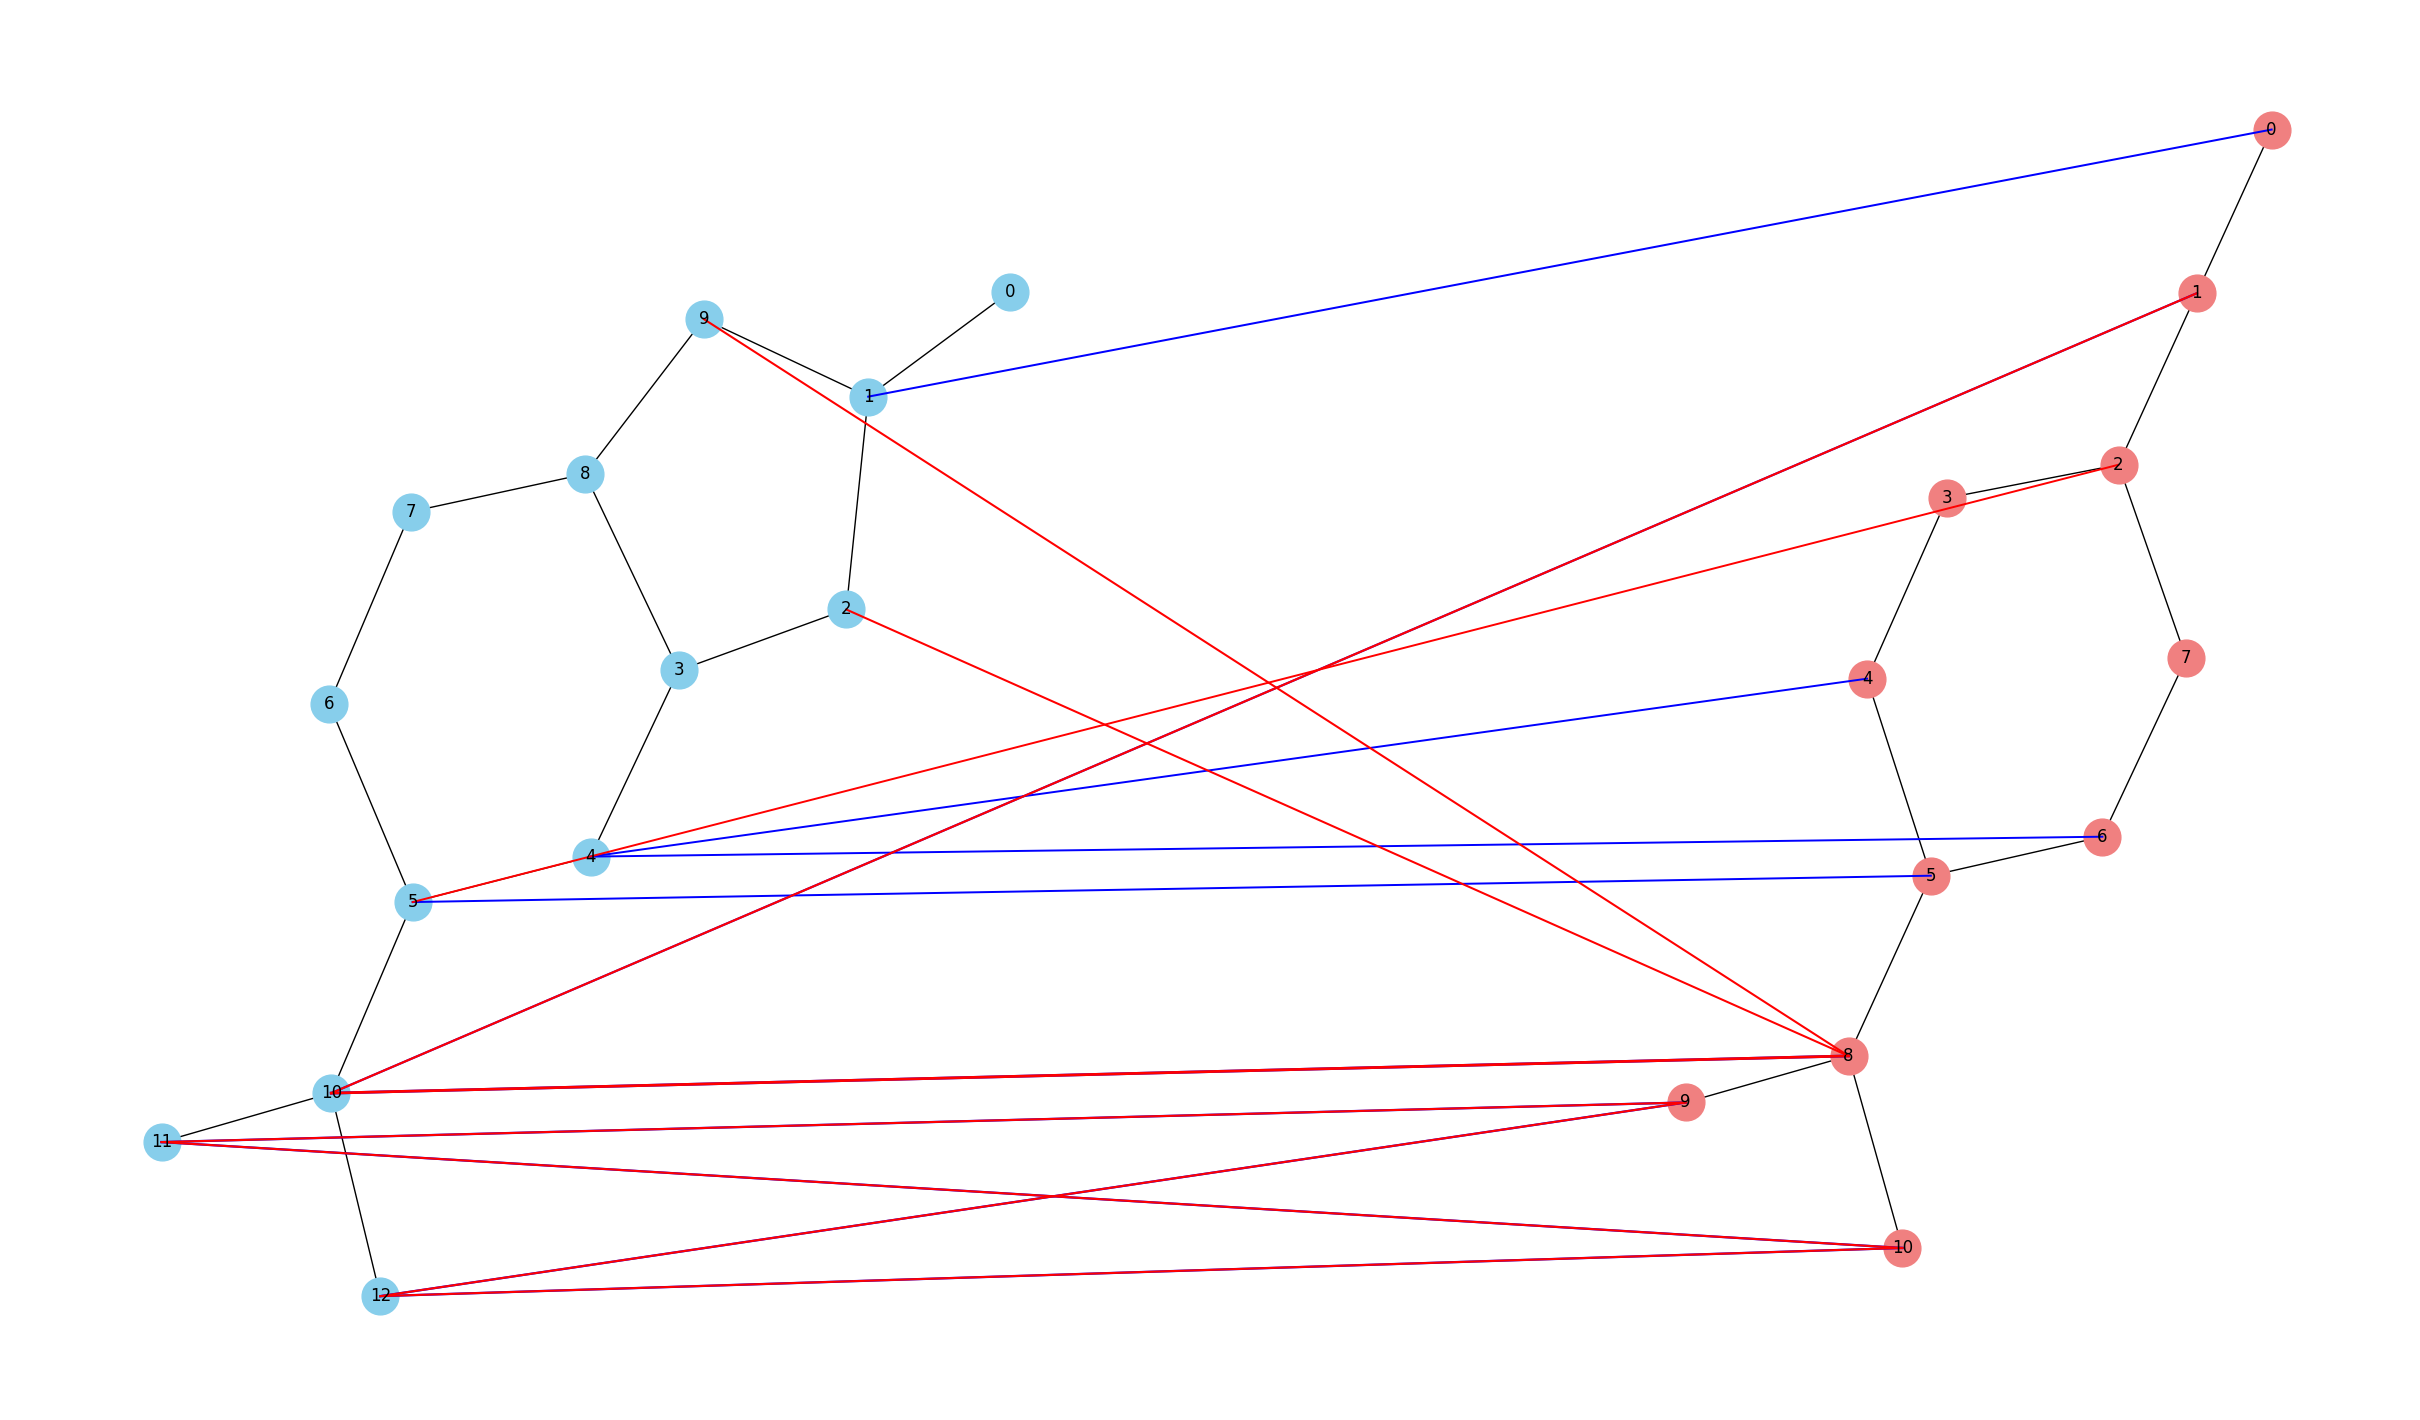

In [39]:
for i in range(len(model._prop_layers)):
    cross_attentions, topk_cross_attentions, a_x_s, a_y_s =  model._prop_layers[i].cross_attention
    visualize_graphs_with_attention(graph1, graph2, a_x_s[0], a_y_s[0], threshold=0.7, topk=5)

In [35]:
for i in range(len(model._prop_layers)):
    print(model._prop_layers[i])

GraphPropMatchingLayer(
  (_message_net): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (_reverse_message_net): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (GRU): GRU(48, 16)
)
GraphPropMatchingLayer(
  (_message_net): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (_reverse_message_net): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (GRU): GRU(48, 16)
)
GraphPropMatchingLayer(
  (_message_net): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (_reverse_mess